## RNN ile Duygu Analizi

#### 1-)Basit RNN ve sorunları
#### 2-)GRU ve LSTM farkı
#### 3-)Uygulamanın anlatılması

Machine Learning ile NLP çalışmaları yürütülürken genelde satır satır çalışılır ve bir önceki satırın bir sonraki satır ile ilişkisi kurulamamaktadır. Dokümanda ya da cümlede geçen kelimelerin ya da harflerin birbiri arasındaki ilişki genellikle istatistiksel olarak hesaplanarak ilerlenir. Bu nedenle çok uzun cümlelerde makine öğrenmesi teknikleri sınıflandırma çalışmalarında çok başarılı değilr. Ancak RNN'de ise her bir kelimenin bir önceki ve bir sonraki kelimeyle arasında ilişkisine bakılır ve cümle içerisindeki yerine, kelimenin cümleye kattığı anlama göre sınıflandırma işlemi gerçekleştirilir.

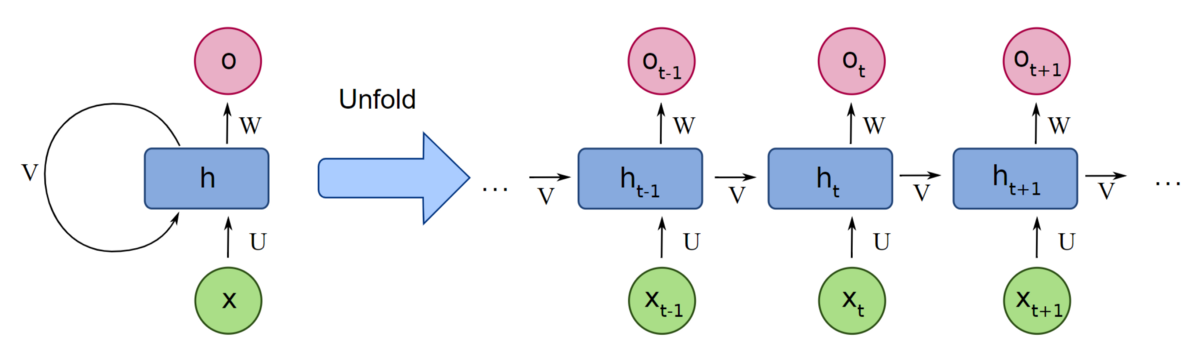

xt = verilen input
ht = önceki adımda üretilen hidden state

Fakat basit RNN'in de birkaç sorunu var. Bu sorunlar kaybolan gradient(vanishing gradient) ile patlayan gradient(exploding gradient). RNN'de backpropagation yaparken loss fonksiyonunun ht-1'e göre kısmi türevi alınıyor.Backpropagation'da matris çarpımı yapılırken weight matrisinin transpozu ile çarpım işlemi yapılması gerekiyor. Geriye doğru gidildikçe sürekli weight matrisi ile çarpma işlemi yapılması durumunda bu buradan çıkacak sayı 1'den büyükse sürekli artarak devam edecektir. İşte bu exploding gradient yani patlayan gradient problemi. Eğer bu sayı 1'den küçükse bu seferde bu sayı giderek azalacaktır ve bir süreden sonra 0 olacaktır. işte bu problem ise vanishing gradient yani kaybolan gradient problemi. Bu problemi giderebilmek için gradient clipping işlemi uygulanabilir yani gradient işlemi bir noktada kesilebilir ancak çok efektif bir çözüm olmayacaktır. Bu nedenle basit RNN yerine LSTM ya da GRU kullanmak daha mantıklı.

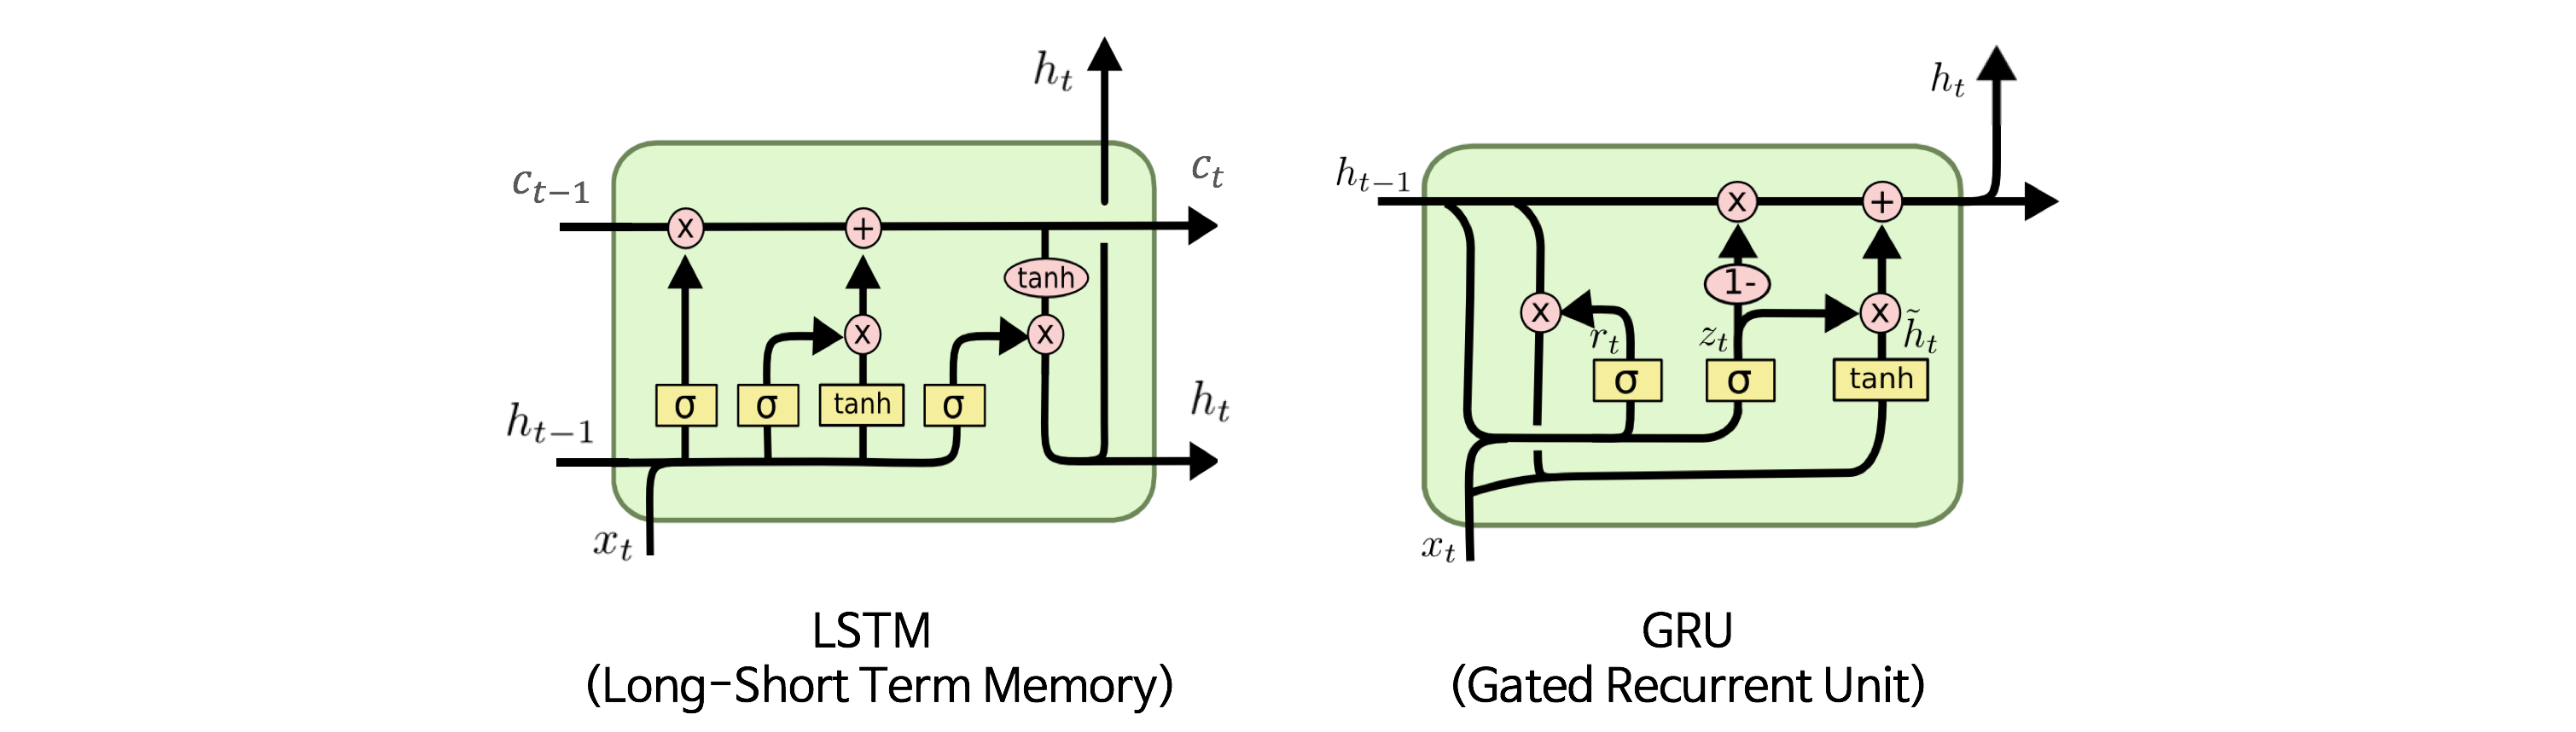

#### LSTM
Cell state = çok fazla işlem olmadığı için bilgi bir sonrakine çok rahat bir şekilde akar.

Forget gate (ilk sigmoid) = unutma geçiti (0 ile 1 arasında sıkıştırılır)

input gate (ikinci sigmoid ve tanh)

output gate (son sigmoid)

#### GRU
LSTM'in bir çeşiti. (2014 yılında)

Cell state yerine hidden state bulunmakta. Forget ve input gate birleştirilip tek bir update gate kullanılmakta.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

/home/serkan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/serkan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/serkan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/serkan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
stop_word_list

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [3]:
dataset = pd.read_excel('sentiment_analysis.xlsx' , sheet_name = 'Sheet1')

In [4]:
dataset

,Text,Sentiment
0,bana beklediğim cevapları vermiyorsun,0
1,senden istediğim cevaplar bunlar değil,0
2,verdiğin yanıtlar doğru değil,0
3,duymak istediğim cevaplar bunlar değil,0
4,seni seviyorum bro,1
...,...,...
19018,J7 Pro Cihazı Geldi Fakat Faturası Gelmedi!,0
19019,Müşteri Hizmetlerine Ulaşamama Sorunu!,0
19020,Para İadesi Sorunu!,0
19021,Mağdur Ediyor!,0


In [5]:
dataset['Text'] = dataset['Text'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
dataset['Text'] = dataset['Text'].apply(lambda x: x.lower())
dataset['Text'] = dataset['Text'].apply(lambda x: x.strip())

def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

dataset['Text'] = dataset['Text'].apply(lambda x: token(x))

In [6]:
dataset['Text']

0             bana beklediğim cevapları vermiyorsun
1            senden istediğim cevaplar bunlar değil
2                     verdiğin yanıtlar doğru değil
3            duymak istediğim cevaplar bunlar değil
4                                seni seviyorum bro
                            ...                    
19018    j7 pro cihazı geldi fakat faturası gelmedi
19019         müşteri hizmetlerine ulaşamama sorunu
19020                           para i̇adesi sorunu
19021                                 mağdur ediyor
19022        ürünü aldığı halde parayı i̇ade etmedi
Name: Text, Length: 19023, dtype: object

In [7]:
data = dataset['Text'].values.tolist()
sentiment = dataset['Sentiment'].values.tolist()

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

In [9]:
x_train[300]

'fiyata iyi süper'

In [10]:
y_train[300]

1

In [11]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data)
tokenizer.word_index

{'bir': 1,
 'ürün': 2,
 'iyi': 3,
 'güzel': 4,
 'tavsiye': 5,
 'gayet': 6,
 'ederim': 7,
 'hızlı': 8,
 'aldım': 9,
 'yok': 10,
 'telefon': 11,
 'olarak': 12,
 'ürünü': 13,
 'göre': 14,
 'kadar': 15,
 '2': 16,
 'var': 17,
 'teşekkürler': 18,
 'elime': 19,
 'fiyat': 20,
 'uygun': 21,
 'kullanışlı': 22,
 'fiyata': 23,
 'ben': 24,
 'gün': 25,
 'değil': 26,
 'kargo': 27,
 'biraz': 28,
 '1': 29,
 'kaliteli': 30,
 'kullanıyorum': 31,
 'kalitesi': 32,
 'geldi': 33,
 'gerçekten': 34,
 'tek': 35,
 'şarj': 36,
 '3': 37,
 'sonra': 38,
 'bi': 39,
 'olması': 40,
 'cok': 41,
 'bence': 42,
 'küçük': 43,
 'kesinlikle': 44,
 'önce': 45,
 'tam': 46,
 'oldu': 47,
 'performans': 48,
 'ses': 49,
 'ulaştı': 50,
 'mükemmel': 51,
 'sorun': 52,
 'fakat': 53,
 'oldukça': 54,
 'fazla': 55,
 'ancak': 56,
 'bile': 57,
 'fiyatına': 58,
 'memnun': 59,
 'hepsiburada': 60,
 'başarılı': 61,
 'şık': 62,
 'fiyatı': 63,
 'uzun': 64,
 'telefonu': 65,
 'memnunum': 66,
 'hızı': 67,
 'ayrıca': 68,
 'sipariş': 69,
 'kolay': 70,

In [12]:
#her bir yorumu aynı boyuta getirmek gerekiyor RNN böyle çalışıyor.
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [13]:
x_train_tokens[300]

[23, 3, 75]

In [53]:
x_train[300]

'fiyata iyi süper'

In [14]:
#her bir yorumun uzunluğu alınır ve bir liste oluşturulur ve numpy array olarak çevrilir.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [15]:
np.mean(num_tokens)

16.413867423645062

In [16]:
np.max(num_tokens)

235

In [17]:
#burada token sayısı ayarlanırken ortalam etrafındaki dikkate alınarak bir sayı belirlenir
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

52

In [18]:
#belirlenen bu sayı verinin yüzde kaçını kapsadığına bakılır.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9599432266204069

In [19]:
#veriler belirlenen token sayısına göre ayarlanır
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [20]:
x_train_pad[3027]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  545,   10, 1834,   15, 9899, 3943,  228, 1817,  195,
        112, 6740,  179,  690,  644,   55,   10, 2689], dtype=int32)

In [21]:
x_test_pad[2000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    2,   49,   32,   58,   14,   61,   45, 5249,
        532,  194,  183,  687, 3116,   56,    3,  123], dtype=int32)

In [22]:
#tokenlaştırılan kelimeler tekrar string hale geitirilmek için bir fonksiyon yazılması gerekiyor.
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

#tokenlaştırılan cümleyi tekrar string hale getirmek
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [23]:
#ardışık bir model
model = Sequential()

#her kelimeye karşılık gelen 50 uzunluğunda bir vektör oluşturulur. (Embedding matrisi)
embedding_size = 50

#matris kelime sayısı ve embedding büyüklüğünde olacak, yani 10bine 50 uzunluğunda. Buna da bir isim veriliyor name değişkeniyle.
model.add(Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
#LSTM layerlerinin eklenmesi
## 16 nöronlu LSTM (16 outputlu , return_sequences=True demek output'un tamamını ver demek)
model.add(LSTM(units=16, return_sequences=True))
## 8 nöronlu LSTM (8 outputlu , return_sequences=True demek output'un tamamını ver demek)
model.add(LSTM(units=8, return_sequences=True))
## 4 nöronlu LSTM (4 outputlu , return_sequences=False yani default değer, tek bir output verecek)
model.add(LSTM(units=4))
## output layer'ı , görsel olarak gösterilirken dense layer kullanılır.  Tek bir nörondan oluştuğu için 1 yazılır.
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
#optimizasyon algoritması, 1e-3 = 0.001 demek.
optimizer = Adam(lr=1e-3)

In [26]:
#modeli derlemek, loss fonksiyonu binary_crossentropy -> sadece 2 sınıf ama daha fazla sınıflar için categorical_crossentropy kullanılır.
#metrics -> modelin başarısını görmek için.
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 52, 50)            500000    
_________________________________________________________________
lstm (LSTM)                  (None, 52, 16)            4288      
_________________________________________________________________
lstm_1 (LSTM)                (None, 52, 8)             800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 505,301
Trainable params: 505,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
#model eğitimi, bir defa eğitimden geçmesi -> epoch , batch_size -> 256'şar 256'şar beslenecek.
history = model.fit(x_train_pad, y_train,validation_split=0.25, epochs=5, batch_size=256)

Train on 11413 samples, validate on 3805 samples
Epoch 1/5
11413/11413 [==============================] - 6s 531us/sample - loss: 0.6044 - acc: 0.7193 - val_loss: 0.5151 - val_acc: 0.7874
Epoch 2/5
11413/11413 [==============================] - 4s 377us/sample - loss: 0.4568 - acc: 0.8209 - val_loss: 0.4008 - val_acc: 0.8478
Epoch 3/5
11413/11413 [==============================] - 4s 379us/sample - loss: 0.3152 - acc: 0.9025 - val_loss: 0.3088 - val_acc: 0.8786
Epoch 4/5
11413/11413 [==============================] - 5s 401us/sample - loss: 0.2239 - acc: 0.9407 - val_loss: 0.2690 - val_acc: 0.9017
Epoch 5/5
11413/11413 [==============================] - 4s 377us/sample - loss: 0.1613 - acc: 0.9642 - val_loss: 0.2499 - val_acc: 0.9083


In [29]:
model.save("sentiment_model.h5")

In [30]:
#test edip çıkan sonuçları result değişkenine atıyoruz.
result = model.evaluate(x_test_pad, y_test)

3805/3805 [==============================] - 2s 517us/sample - loss: 0.2513 - acc: 0.9083


In [31]:
result[1]

0.9082786

In [56]:
y_pred = model.predict_classes(x=x_test_pad[:700])

In [57]:
y_pred = y_pred.T[0]

In [58]:
y_pred

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [65]:
text = "çok güzel bir film olduğunu düşündüğünü söyledi, ancak ben fikrine katılmıyorum"
texts = [text]
tokens = tokenizer.texts_to_sequences(texts)

In [66]:
tokens_pad = pad_sequences(tokens,maxlen = max_tokens)
tokens_pad.shape

(1, 52)

In [67]:
print("moralinizin {} olduğunu görüyorum. ".format(model.predict_classes(tokens_pad).tolist()[0][0]))

moralinizin 1 olduğunu görüyorum. 


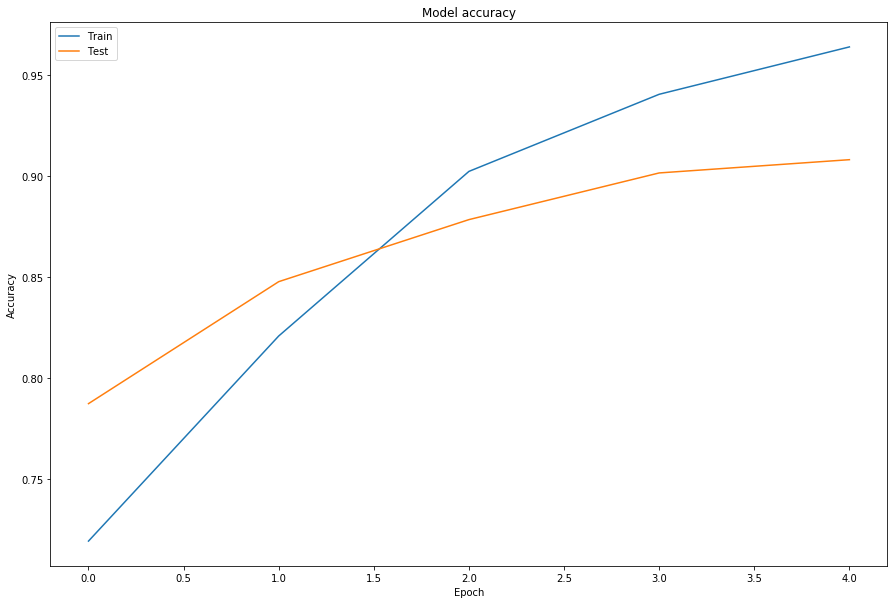

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

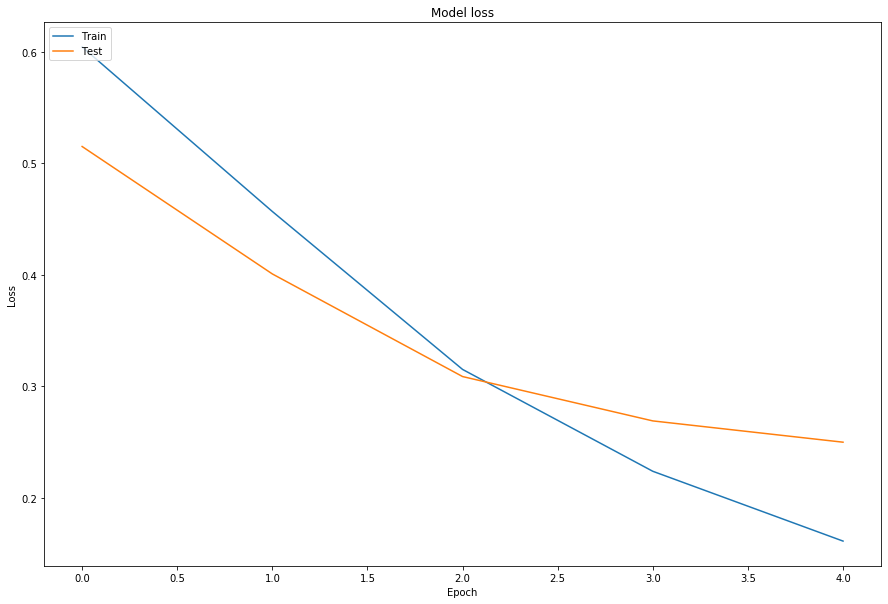

In [64]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()